# Microhaplotype candidate panel selection

The aim of this notebook is to analyse all the per-window summary statistics generated in the first notebook, explores panel optimisation and use them to assemble a candidate panel set of markers. The selection process is a challenging mathematical optimisation problem, so here we provide two complementary and effective ways to perform the task. It is worth mentioning that while we show selection methods here, often a subsequent manual curation would be required because of certain constraints, downstream requirements or other considerations (proximity to other markers, reduction of gaps across the genome, low/high diversity regions, or individual assay/panel performance during experimental validation, etc.)The codebase is also modular and can be extended to use different optmisation algorithms if required. 


The notebook consists of three parts:
1. [Environment and data](Environment-and-data)
1. [Data exploration](Data-exploration)
1. [Candidate selection](Candidate-selection) using two different approaches
    1. ["Greedy" candidate selection]("Greedy"-candidate-selection)
    1. [Evenly-spaced candidate selection](Evenly-spaced-candidate-selection)

All the data required to run this notebook, as well as the dataframes/files generated in the previous (Notebook 1_evaluating_marker_candidates) are also provided pre-calculated in this repository.

## Environment and data

This notebook can be run from any computer and can also work from a compute node within Google Cloud, for example via MyBinder or Google Colab which are free interactive computing services running in a cloud environment. Here we only use common packages that come pre-installed in many computing environments, without strong version dependencies.

First, we will load all required packages to get started. 

In [78]:
# Load all required packages and print their version
from importlib.metadata import version
from itertools import cycle

print(f'Numpy version: {version("numpy")}')
print(f'Pandas version: {version("pandas")}')
print(f'Matplotlib version: {version("matplotlib")}')
print(f'scikit-allel version: {version("scikit-allel")}')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import allel

# Setup plotting backend
%matplotlib inline

Numpy version: 1.23.5
Pandas version: 2.2.0
Matplotlib version: 3.8.2
scikit-allel version: 1.3.7


### Loading the data

Next, we need to load the per-window summary statistics generated in the previous notebook, and prepare the dataframe `windows_df` for analysis. In this example, we use the pre-calculated statistics file stored in this repo called `precomputed/genome_stats.csv`. This can be changed to use a different dataset if required, simply direct it to your file of choice in the first line below. 

We then sort our `windows_df` by chromosome, and then add a column that calculates the midpoint between the `window_start` and `window_end` which will be helpful when we begin to visualise our windows data.

In [79]:
windows_df = pd.read_csv("../precomputed/genome_stats.csv", index_col=0)
windows_df = windows_df.sort_values('chrom')
# Add a supplementary column containing the window midpoint, useful for plotting
windows_df = windows_df.assign(midpoint=windows_df.loc[:, ["window_start", "window_end"]].mean(axis=1))
windows_df.head()

,chrom,window_start,window_end,variant_counts,unique_allele_counts,unique_alleles_with_missing_index,unique_alleles_with_het_index,unique_allele_frequencies,unique_allele_count,entropy,het,midpoint
0,PvP01_01_v1,121493,121692,1,[387 3 225],[],[1],"[0.6292682926829268, 0.004878048780487805, 0.3...",3,0.685315,0.470149,121592.5
381,PvP01_01_v1,634843,635042,4,[ 1 30 46 1 2 1 6 202 3 252 23 ...,"[0, 5, 6, 12]","[4, 8, 11]","[0.0016260162601626016, 0.04878048780487805, 0...",17,1.605061,0.711957,634942.5
382,PvP01_01_v1,634893,635092,3,[ 1 6 235 3 252 23 1 1 4 31 51 7],"[0, 1, 7]","[3, 6]","[0.0016260162601626016, 0.00975609756097561, 0...",12,1.399306,0.674974,634992.5
383,PvP01_01_v1,634943,635142,2,[ 1 7 239 3 283 1 51 30],"[0, 1]","[3, 5]","[0.0016260162601626016, 0.011382113821138212, ...",8,1.176073,0.627811,635042.5
384,PvP01_01_v1,634993,635192,1,[ 8 291 3 313],[0],[2],"[0.013008130081300813, 0.47317073170731705, 0....",4,0.780273,0.516893,635092.5


We can also quickly check to see how many unique windows were identified in our previous notebook. 

In [80]:
windows_df.shape[0]

13489

Using our selection criteria from Notebook 1, we can see that we have **13,489 potential microhaplotype markers** to choose from across the 14 chromosomes. 

As this analysis is limited to the core genome, we also need to load the boundaries of those regions, which are provided as part of the MalariaGEN Pv4 data package.

In [81]:
pv_regions = pd.read_csv("../supplementary_files/Pv4_regions.bed",
                         sep="\t", comment="t",
                         names=["chrom", "chromStart", "chromEnd", "name"])

# Coordinates are stored as 0-based in the file and need to be adjusted
pv_regions[["chromStart", "chromEnd"]] += 1
# Out of convenience, we add a 'length' column and filter out all non-core regions
pv_regions["length"] = pv_regions["chromEnd"] - pv_regions["chromStart"]
pv_core = pv_regions[pv_regions["name"]=="Core"]
pv_core.head()

,chrom,chromStart,chromEnd,name,length
1,PvP01_01_v1,116542,677963,Core,561421
3,PvP01_01_v1,679790,903592,Core,223802
6,PvP01_02_v1,100156,162349,Core,62193
8,PvP01_02_v1,164088,745644,Core,581556
11,PvP01_03_v1,108062,630664,Core,522602


## Data exploration

This section of the notebook is not strictly required for the subsequent panel selection and can be skipped. However, it provides some basic insights into the diversity of the genome that can later be used to make more informed decisions on marker selection.

We now load our desired plotting colour palette, then define the plotting parameters below. As we previously calculated the `midpoint` of each window, it will allow us to plot and visualise the windows easier. 

In [82]:
# Rich rainbow colour palette
rainbow_palette = ['#C62828','#D81B60','#8E24AA','#5E35B1','#3949AB','#1E88E5','#039BE5',
               '#00ACC1','#00897B','#43A047','#7CB342','#C0CA33','#FFB300','#F4511E']

In [83]:
def plot_man(df, column, palette=["#276FBF", "#183059"]):

    rcParams = plt.rcParams
    rcParams["font.size"] = 12
    rcParams["axes.labelsize"] = 12

    plt.rcParams["xtick.labelsize"]=12
    plt.rcParams["ytick.labelsize"]=12

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xlabel("Chromosome")
    ax.set_ylabel(f'"{column}" per window')

    # Map chromosome numbers to names
    chromosomes = np.sort(df["chrom"].unique())
    chrom_dict = dict(zip(chromosomes, cycle(palette)))

    # Plot the values
    df = df.sort_values(["chrom", "midpoint"])
    ax.scatter(np.arange(len(df)),df[column],c=df["chrom"].apply(lambda x: chrom_dict[x]), s=df[column])

    # Plot the X tick marks
    boundaries = np.nonzero(df["chrom"].shift(1, fill_value=df["chrom"].head(1)) != df["chrom"])
    boundaries = np.insert(boundaries, 0, 0)
    boundaries = np.append(boundaries, len(df))
    ticks = [(a + b) / 2 for a, b in zip(boundaries, boundaries[1:])]
    plt.xticks(ticks, np.arange(1, 15), rotation = 45)

    fig.tight_layout()

We can then decide to visualise the number of SNPs present in each of the 13,489 microhaplotype windows, where each datapoint represents one window. The core regions are plotted concatenated across the 14 chromosomes to look at the distribution of windows in the accessible genome. 

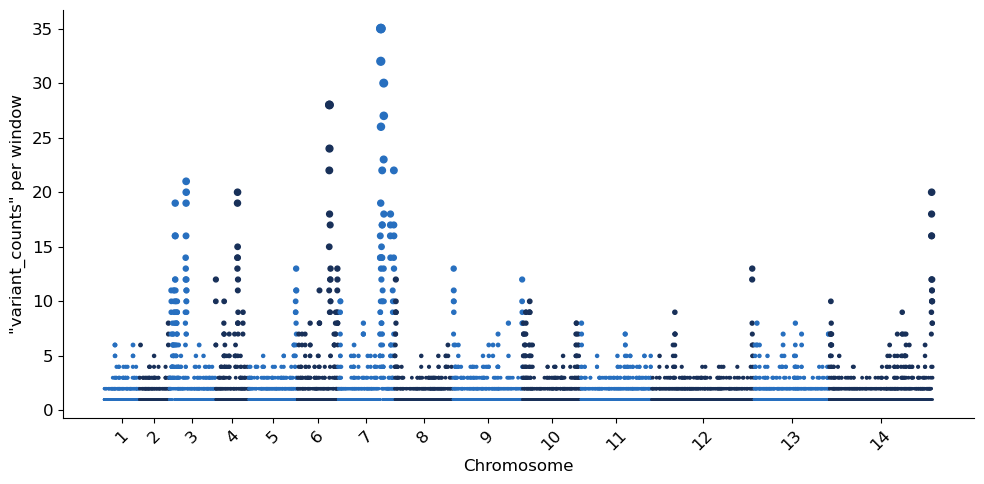

In [84]:
# Plot the number of SNPs per microhaplotype window
plot_man(windows_df, 'variant_counts')
# plot_man(windows_df, 'variant_counts', rainbow_palette) # for a more colorful version

Here we can see from the above plot that the vast majority of the windows have 5 variants or less. We can also enumerate the frequency of `variant_counts` to see how common each one is. 

In [85]:
windows_df['variant_counts'].value_counts()

variant_counts
1     9607
2     2379
3      709
4      290
5      142
6       92
7       68
8       41
9       35
10      31
11      17
12      17
14      10
13      10
16       8
17       5
19       4
18       4
20       3
15       3
22       3
28       2
35       2
21       1
24       1
23       1
30       1
27       1
32       1
26       1
Name: count, dtype: int64

Alternatively, we can visualise the **global heterozygosity** per microhaplotype window, which indicates the overall level of informativeness contained in a given window. In simple terms, heterozygosity in this context can be described as the likelihood of any two parasites having **different** alleles at each microhaplotype (multiallelic) locus. So the higher the heterozygosity value for any window, the higher the chance that any two global parasite lineages selected from the dataset will be unique from each other. Heterozygosity is a valuable statistic to quantify marker informativeness, especially in the context of being able to capture parasite relatedness relationships from sparse data (such as a genotyping panel). 

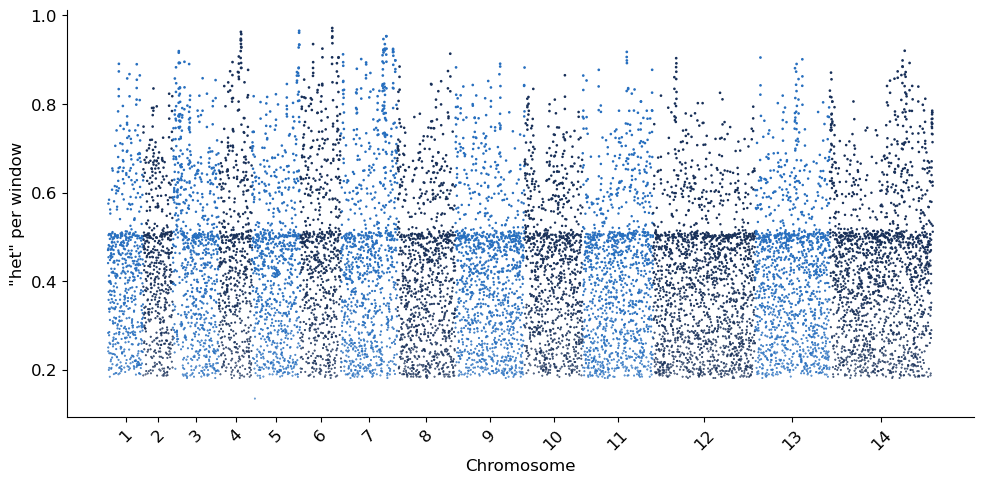

In [86]:
plot_man(windows_df, 'het')

Another classical measure of information content can be quantified by calculating entropy, for more details on this, see [information theory](https://en.wikipedia.org/wiki/Entropy_(information_theory). We can plot the relationship between heterozygosity and entropy below for comparison.   

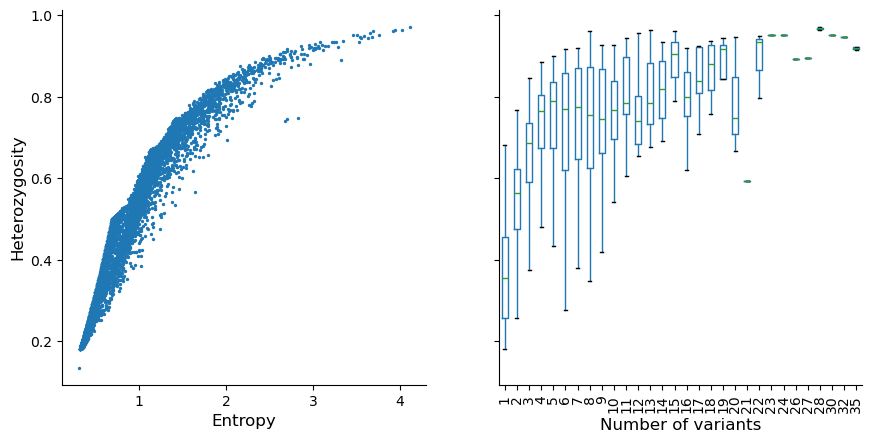

In [87]:
def plot_het_v_entropy(df):

    rcParams = plt.rcParams
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 12

    plt.rcParams['xtick.labelsize']=10
    plt.rcParams['ytick.labelsize']=10

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.scatter(df['entropy'], df['het'], s=2)
    ax1.set_xlabel('Entropy')
    ax1.set_ylabel('Heterozygosity')

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    boxplot = df.boxplot(column='het', by='variant_counts',
                         rot=90, grid=False, showfliers=False,
                         ax=ax2)
    
    ax2.set_xlabel('Number of variants')
    ax2.set_ylabel('')
    ax2.title.set_text('')
    fig.suptitle('')

plot_het_v_entropy(windows_df)

The left plot indicates that heterozygosity and entropy (both measures of informativeness) are correlated, so for simplicity we have only decided to use heterozygosity as an example here.  

The right plot shows that as the number of variants increases, heterozygosity approaches 1 with diminishing returns as variant count increases, so we decided not to select any windows with more than 10 variants, considering that the number of possible haplotypes exponentially increases. The larger the number of possible haplotypes, the more challenging downstream analyses become computationally (as well as the potential implications on error rate that are compounded with each additional variant per window), so it is pragmatic to keep the number of variants per window as low as possible without sacrificing informativeness. Additionally, there is a considerable increase in information content in 3 or more variants, so taken together, we applied cutoffs that all candidate microhaplotype windows should contain between 3 and 10 variants. 

## Candidate selection
Panel selection can be seen as a complex and multidimensional optimisation problem. As shown in [Taylor et al, Genetics 2019](https://doi.org/10.1534/genetics.119.302120), there are several dimensions on which optimal markers should be selected for relatedness estimations. Important considerations from this publication suggest to choose evenly spaced markers across the genome, while simultaneously maximising marker diversity. Additionally, around 100 multiallelic markers were shown to provide sufficient resolution for reconstructing relatedness relationships. From a practical standpoint, there is a trade-off between what is ideal for informativeness maximisation, and even-spacing of markers across the entire genome space. Further, what is reasonable for assay design and implementation of the panel in real-world settings needs to be considered (i.e. number of markers included in an assay, primer design constraints, or how to analyse complex multiallelic data readouts with hundreds/thousands of possible allele combinations). As there are several ways to approach it, here we provide two examples (**greedy** and **evenly spaced**), with the expectation that some level of manual curation will be required to arrive at a final marker set, striking a balance between informativeness, even spacing of markers, and all of the additional considerations needed throughout experimental assay design and marker validation.

### Utility functions

To guarantee that all core regions are represented, we want microhaplotypes to be distributed proportionally to the size of each core region. The utility function below does that and returns the number of expected microhaplotypes per core region, also accounting for rounding errors. This is designed to distribute the number of marker counts proportional to the core region size. **Note: this utility function does not space the markers themselves, it simply calculates the number of markers required per core region's length.**

In [88]:
def get_n_muhap_per_core(df, n_muhap_total):
    core_length = sum(df["length"])
    # First try with a naive distribution proportional to the region size
    n_muhap_per_core = np.round((df["length"]/core_length)*n_muhap_total).astype('int')

    # Check whether the number obtained is what is required (i.e. if there are rounding effects)
    delta = n_muhap_total - sum(n_muhap_per_core)

    # Supplement the smallest (or deplete the largest) regions if an adjustment is required
    if delta > 0: # Less markers than expected, add to the smallest
        smallest = n_muhap_per_core.nsmallest(delta).index
        n_muhap_per_core[smallest] += 1
    elif delta < 0: # More markers than expected, remove from the largest
        largest = n_muhap_per_core.nlargest(-delta).index
        n_muhap_per_core[largest] -= 1
    
    return n_muhap_per_core

We can then create a visual representation of marker positions across the genome, where:
* red = subtelomeric regions
* orange = internal hypervariable regions
* white = core regions
* black line = marker location

So we define the palette, and the plotting parameters below. 

In [89]:
regions_pal = {"Cen": "blue", "Core":"white", "In":"orange" , "Sub":"red"}

In [90]:
def plot_markers(markers, regions):

    rcParams = plt.rcParams
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 10

    #plt.rcParams['xtick.labelsize']=10
    #plt.rcParams['ytick.labelsize']=10
    
    fig, ax = plt.subplots(nrows=14, sharex = True, sharey = True, figsize=(10, 10))

    ax[0].set_xlim([0,regions["chromEnd"].max()])
    ax[0].set_ylim([0,1])
    ax[0].get_xaxis().get_major_formatter().set_scientific(False)
    ax[0].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    for chr_num in range(0,15):
        chr_name = f'PvP01_{chr_num:02}_v1'
    
        chr_regions = regions[regions["chrom"] == chr_name]
        chr_markers = markers[markers["chrom"] == chr_name]

        ax[chr_num-1].spines['right'].set_visible(False)
        ax[chr_num-1].spines['top'].set_visible(False)
        ax[chr_num-1].spines['left'].set_visible(False)

        for _, r in chr_regions.iterrows():
            p = mpl.patches.Rectangle((r["chromStart"], -1), r["length"], 2, edgecolor='None', facecolor=regions_pal[r["name"]])
            ax[chr_num-1].add_patch(p)

        ax[chr_num-1].vlines(chr_markers["window_start"],-1,1, color="black") 
        ax[chr_num-1].set_ylabel(chr_name, rotation='horizontal', ha='right')
        ax[chr_num-1].set_yticks([])

### Greedy

Here we show a method to maximise informativeness at the expense of other considerations, where within each core region, the proportional number of markers (previously calculated above) are selected only on their window's heterozygosity statistic, with the highest heterozygosity windows selected regardless of location in the core region. Then, as a second step, you can apply spacing considerations - where the minimum space between markers can be applied (here 1000 bp of space between markers has been set as the default parameter). In the event that the correct number of markers cannot be found for a region, it gives a warning where it fails to retrieve the desired number of markers per core region. 

For more information, see [Greedy optimisation](https://en.wikipedia.org/wiki/Greedy_algorithm). 

In [99]:
def get_greedy_muhap_list(df, core, n_muhap_per_core, min_distance=1_000):
    
    muhap_list = []
    
    for (_, row), n_core in zip(core.iterrows(), n_muhap_per_core):
        core_windows = df[ (df["chrom"] == row["chrom"]) &
                           (df["window_start"] >= row["chromStart"]) &
                           (df["window_end"] <= row["chromEnd"]) ].copy()
        
        local_list = []
        
        while len(local_list) < n_core:
            core_windows.sort_values("het", ascending=False, inplace=True)
            if not np.isnan(core_windows.iloc[0]["midpoint"]):
                local_list += [core_windows.index[0].tolist()]
                midpoint = core_windows.iloc[0]["midpoint"]
                core_windows.mask( abs(core_windows["midpoint"] - midpoint) < min_distance, inplace=True)
            else:
                print(f'Only {len(local_list)} out of {n_core} windows found in \
{row["chrom"]}:{row["chromStart"]}-{row["chromEnd"]} - try decreasing min_distance')
                break
   
        muhap_list += local_list
    
    return muhap_list


We can then apply our heuristic filters we decided on earlier for choosing only windows that have between 3 and 10 variants per window with `windows_subset` which can be changed, depending on needs. 

In [92]:
windows_subset = windows_df[windows_df["variant_counts"].between(3,10)]

We can then create our **greedy** microhaplotype selection list, and ask for a panel with 100 microhaplotypes - this can be changed as needed. You can then specify the minimum distance between markers, here we have set it to 25,000 as an example. 

In [93]:
n_muhap_total = 100
n_muhap_per_core = get_n_muhap_per_core(pv_core, n_muhap_total)
greedy_muhap_list = get_greedy_muhap_list(windows_subset, pv_core, n_muhap_per_core, 25_000)

Let's plot our greedy microhaplotype marker selection. 

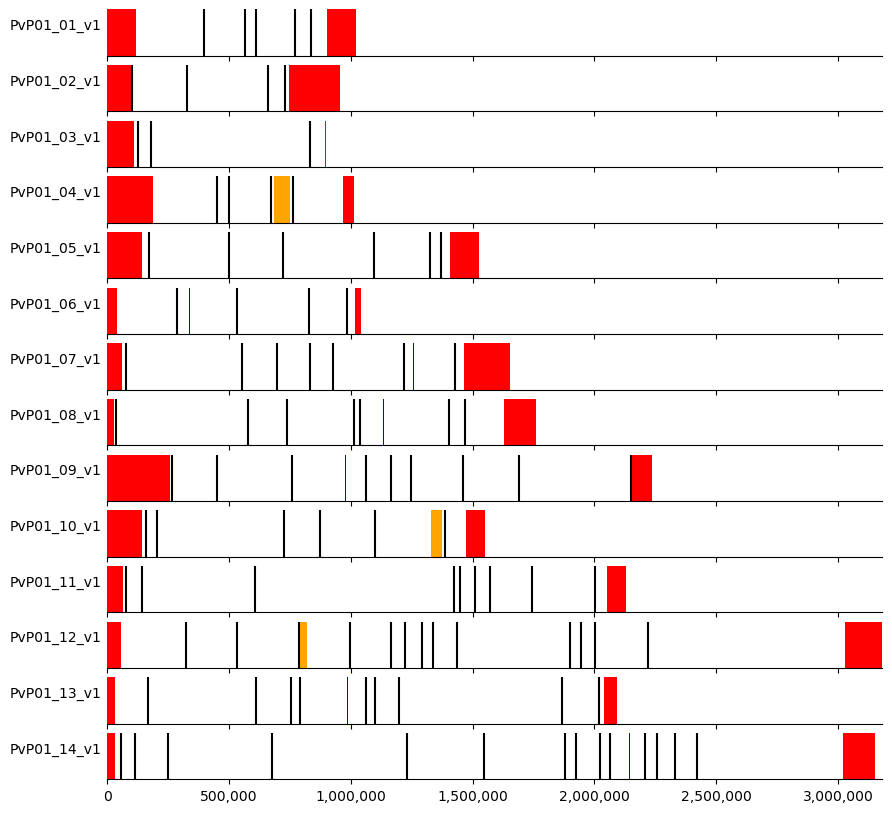

In [94]:
plot_markers(windows_subset.loc[greedy_muhap_list], pv_regions.sort_values(["chrom","chromStart"]))

We can see that for a marker set of 100, when the markers are prioritised while optimising on informativeness criteria first, and spacing second, there are large gaps between markers, and also regions of the genome where markers clump together (likely higher-diversity regions). If we change the minimum distance (for example to 75,000), we can space them more evenly. 

### Evenly spaced

Now we can optimise based on spacing as a first priority, and informativeness as a second priority. This approach decides the minimum spacing desired between markers (default=1000) and then divides each core region into equal sized segments (proportional to the number of markers required per core region), leaving the desired minimum distance gap in between the segments. Then, a sliding window is moved through each segment, identifying the highest heterozygosity marker window within it. 

In [95]:
def get_max_idx(df):
    return df.idxmax()

def get_even_muhap_list(df, core, n_muhap_per_core, spacing=1_000, verbose=False):

    muhap_list = []

    for (_, row), n_core in zip(core.iterrows(), n_muhap_per_core):
        core_windows = df[ (df["chrom"] == row["chrom"]) &
                           (df["window_start"] >= row["chromStart"]) &
                           (df["window_end"] <= row["chromEnd"]) ].copy()

        core_windows.sort_values("window_start", inplace=True)
        
        local_list = []

        if n_core > 0:
            win_size = np.max([0, np.ceil(row["length"]/n_core).astype("int") - spacing])
            local_list, a, NN = allel.windowed_statistic(core_windows["midpoint"].astype("int"), core_windows["het"], get_max_idx,
                                                         size=win_size, step=win_size+spacing,
                                                         start=row["chromStart"], stop=row["chromEnd"])
            if np.isnan(local_list).any():
                print(f'Only {np.count_nonzero(NN)} out of {n_core} windows found in \
{row["chrom"]}:{row["chromStart"]}-{row["chromEnd"]}')
                if verbose:
                    print(f'L:{row["length"]}, W:{win_size}, N:{n_core}')
                    print(a)
                    print(NN)
                local_list = local_list[~np.isnan(local_list)].astype("int")

        muhap_list = [*muhap_list, *local_list]
    
    return muhap_list

Now, we will once again choose which marker windows we would like (variant counts between 3 and 10). 

In [96]:
windows_subset = windows_df[windows_df["variant_counts"].between(3,10)]

We will similarly require 100 markers to be selected, and a minimum distance of 25,000

In [97]:
n_muhap_total = 100
n_muhap_per_core = get_n_muhap_per_core(pv_core, n_muhap_total)
even_muhap_list = get_even_muhap_list(windows_subset, pv_core, n_muhap_per_core, 25_000)
len(even_muhap_list)

Only 2 out of 3 windows found in PvP01_01_v1:116542-677963
Only 0 out of 1 windows found in PvP01_04_v1:566928-685686
Only 5 out of 6 windows found in PvP01_07_v1:60454-1256419
Only 4 out of 5 windows found in PvP01_08_v1:28424-1132375
Only 3 out of 4 windows found in PvP01_10_v1:140990-1011339


95

Here, we can see that if we optimise on spacing first, we cannot get the desired number of markers (100), only 95 are returned. We can adjust the spacing and number of markers until we can select the desired number. 

Let's plot our **evenly spaced** microhaplotype selection. 

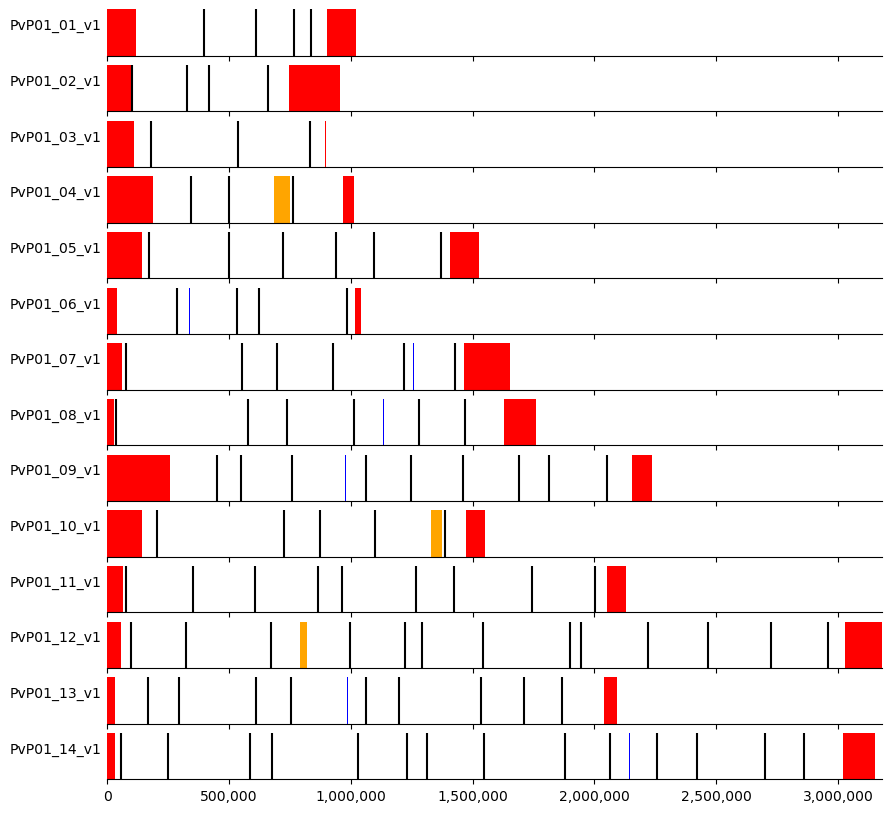

In [98]:
plot_markers(windows_subset.loc[even_muhap_list], pv_regions.sort_values(["chrom","chromStart"]))

As we can see, there is a definite improvement in spacing of markers, however, a drawback to this approach is that we could be ignoring good microhaplotype windows with high informativeness by insisting that the spacing be consistent between markers. 